In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

In [0]:
def get_features_imputed(path):

    """
    Reading in all_customer_data (except complaints) and imputes null values

    Parameters:
    - path (str): the local path to all_customer_data without complaints

    Returns:
    - hbb_features_reduced (DataFrame): features filtered & imputed
    - numerical_cols (list): list of numerical features
    - categorical_cols (list): list of categorical features
    """
    
    # hbb_pdf is all_customer_data for 60-30 model except the complaints!
    hbb_pdf = pd.read_csv(path, index_col=0)

    # For HBB model, we don't need houseflag features
    hbb_pdf = hbb_pdf.drop(['Houseflag', 'ACQ_DATE_CUSTOMER', 'START_DATE', 'END_DATE', 'pcdsht', 'region'], axis=1)
    hbb_pdf = hbb_pdf.drop_duplicates()

    # Model will be at the CUSTOMER KEY + SUBSCRIBER KEY level
    hbb_pdf.insert(0, 'cus_subs_key', hbb_pdf['CUSTOMER_KEY'].astype(str) + '_' + hbb_pdf['SUBSCRIBER_KEY'].astype(str))
    hbb_pdf = hbb_pdf.drop(['CUSTOMER_KEY', 'SUBSCRIBER_KEY'], axis=1)
    hbb_pdf.columns = [col.lower() for col in hbb_pdf.columns]

    # Dropping non-feature/response columns
    nonfeature_cols = ['model_date', '30d_start', '90d_start']
    hbb_pdf = hbb_pdf.drop(nonfeature_cols, axis=1)

    features = hbb_pdf.columns.difference(['cus_subs_key', 'churn_flag', 'set'])

    # Number of unique values per feature
    nunique_features = hbb_pdf[features].nunique().reset_index()
    nunique_features.columns = ['feature', 'n_unique']

    # Number of non-null values per feature
    nnnull_features = (~hbb_pdf[features].isnull()).sum().reset_index()
    nnnull_features.columns = ['feature', 'n_nnull']

    nunique_nnull_features = nunique_features.merge(nnnull_features, on='feature', how='left').sort_values(
        by='n_nnull', ascending=False).reset_index(drop=True)

    # If number of unique values <= 1, the feature doesn't have any explanatory capacity for the response at all!
    bad_features = nunique_nnull_features.loc[nunique_nnull_features['n_unique'] <= 1, 'feature'].values
    hbb_features_reduced = hbb_pdf.drop(bad_features, axis=1).copy()

    feature_datatypes = hbb_features_reduced.dtypes

    # Categorical columns
    categorical_cols = feature_datatypes[feature_datatypes == 'object'].index
    categorical_cols = categorical_cols.difference(['cus_subs_key', 'churn_flag', 'set'])

    # Filling null values for the categorical values with 'Unknown'
    for col in categorical_cols:
        if hbb_features_reduced[col].isnull().any():
            hbb_features_reduced.loc[hbb_features_reduced[col].isnull(), col] = 'Unknown'

    # Numerical columns
    numerical_cols = feature_datatypes[feature_datatypes != 'object'].index
    numerical_cols = numerical_cols.difference(['cus_subs_key', 'churn_flag', 'set'])

    # Ratio of null values per feature
    feature_null_ratio = hbb_features_reduced[numerical_cols].isnull().sum().sort_values(ascending=False).reset_index()
    feature_null_ratio.columns = ['feature', 'null_ratio']
    feature_null_ratio['null_ratio'] = feature_null_ratio['null_ratio'] / len(hbb_features_reduced)

    # Dropping the features with the null ratio > 0.7 (a bit arbitrary but there is a jump just around, i.e. 0.26 to 0.72)
    null_features = feature_null_ratio.loc[feature_null_ratio['null_ratio'] >= 0.7, 'feature'].values
    hbb_features_reduced = hbb_features_reduced.drop(null_features, axis=1).reset_index(drop=True).copy()

    numerical_cols = numerical_cols.difference(null_features)

    # Filling in data_ayce_ind based on gbyte_allowance = AYCE
    hbb_features_reduced.loc[hbb_features_reduced['gbyte_allowance'] == 'AYCE', 'data_ayce_ind'] = 1

    # Incomplete numerical features that could be imputed with zero
    incomplete_numerical = hbb_features_reduced[numerical_cols].isnull().any()
    incomplete_numerical = incomplete_numerical[incomplete_numerical == True].index

    filling_with_zero_cols = ['data_usage_gb', 'data_usage_perc', 'voice_usage_min', 'int_bill_enq', 
                            'mean_bill_prev_balance_amt', 'mean_bill_pym_received_amt', 'std_bill_prev_balance_amt', 'std_bill_pym_received_amt', 'ave_uniq_nums_dialled', 'count_of_molo_calls', 'count_of_on_net_calls', 'count_of_voice_calls', 'fah_roaming_data', 'fah_time', 'int_total',
                            'mean_data', 'mean_recurring_chrg_amt', 'std_recurring_chrg_amt', 'mean_total_due_amt','std_total_due_amt', 'mean_voice', 'stddev_data', 'stddev_voice', 'voice_time',
                            'int_comp_better_offer', 'int_network', 'int_new_ph_con', 'int_offers_enq', 'int_refund_enq', 'int_tariff_enq', 'int_tech_enq', 'int_want_better_deal', 'int_want_cancel', 'int_want_dat_addon', 'int_want_upgrade', 'outcome_case_raised', 'outcome_cons_offer', 'amount_of_data',
                            'molo_time', 'onnet_time', 'out_of_bundle_time', 'count_of_fah_calls', 'wtc_calls',
                            'acc_acq_rec', 'accs_upgrade',
                            'mbs_alloc_50', 'mbs_alloc_75', 'mbs_alloc_90', 'mbs_alloc_all']

    hbb_features_reduced[filling_with_zero_cols] = hbb_features_reduced[filling_with_zero_cols].fillna(0)

    # Imputing age & three_tenure temporarily with the means:
    hbb_features_reduced[['age', 'three_tenure']] = hbb_features_reduced[['age', 'three_tenure']].fillna(hbb_features_reduced[['age', 'three_tenure']].mean())

    return hbb_features_reduced, numerical_cols, categorical_cols

In [0]:
def encoding_categorical_features(hbb_features_reduced, categorical_cols):
    
    """
    Encoding categorical features

    Parameters:
    - hbb_features_reduced (DataFrame): features
    - categorical_cols (list): list of categorical features

    Returns:
    - hbb_transform (DataFrame): features with the categorical features transformed
    """

    # Start with ordinality assumption for simplicity...
    ordinal = OrdinalEncoder()
    X_categorical = pd.DataFrame(ordinal.fit_transform(hbb_features_reduced[categorical_cols].astype(str)), columns=categorical_cols)
    hbb_transform = hbb_features_reduced.copy()
    hbb_transform[categorical_cols] = X_categorical

    return hbb_transform

In [0]:
def get_train_test_sets(hbb_transform):

    """
    Splitting train-test set

    Parameters:
    - hbb_transform (DataFrame): pre-processed features

    Returns:
    - X_train (DataFrame): train feature set
    - X_test (DataFrame): test feature set
    - y_train (Series): train response set
    - y_test (Series): test response set
    """

    X_train = hbb_transform[hbb_transform['set'] == 'train'].drop(['cus_subs_key', 'churn_flag', 'set'], axis=1)
    X_test = hbb_transform[hbb_transform['set'] == 'test'].drop(['cus_subs_key', 'churn_flag', 'set'], axis=1)

    y_train = hbb_transform.loc[hbb_transform['set'] == 'train', 'churn_flag']
    y_test = hbb_transform.loc[hbb_transform['set'] == 'test', 'churn_flag']

    return X_train, X_test, y_train, y_test

In [0]:
def get_rfecv(X_train, y_train):

    """
    Recursive feature elimination with cross-validation
    Estimator is Random Forest

    Parameters:
    - X_train (DataFrame): train feature set
    - y_train (Series): train response set

    Returns:
    - rfecv (sklearn.feature_selection._rfe.RFECV): rfecv result set
    """
    
    # Recursive feature elimination with cross-validation
    model = RandomForestClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    rfecv = RFECV(model, min_features_to_select=5, step=5, cv=cv, scoring='f1')
    rfecv = rfecv.fit(X_train, y_train)

    return rfecv

def get_feature_ranking(X_train, rfecv):

    """
    Getting feature ranking from cross-validated rfecv

    Parameters:
    - X_train (DataFrame): train feature set
    - rfecv (sklearn.feature_selection._rfe.RFECV): rfecv result set

    Returns:
    - rfe_feature_ranking (DataFrame): feature ranking
    """

    # Get feature ranking with in-sample f1 scores
    rfe_feature_ranking = pd.DataFrame(X_train.columns, columns=['feature'])
    rfe_feature_ranking['rank'] = rfecv.ranking_
    rfe_feature_ranking = rfe_feature_ranking.sort_values('rank').reset_index(drop=True)
    scores = pd.DataFrame([np.mean(scores) for scores in rfecv.grid_scores_], columns=['f1'])
    scores['rank'] = range(1,len(scores)+1)
    rfe_feature_ranking = rfe_feature_ranking.merge(scores, on='rank', how='left')
    # rfe_feature_ranking.to_csv('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/rfe_feature_ranking_v0.csv')

    return rfe_feature_ranking

In [0]:
# Reading and imputing datasets..
hbb_features_reduced, numerical_cols, categorical_cols = get_features_imputed('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/hbb_no_comp_60_30.csv')

# Transforming categorical features..
hbb_transform = encoding_categorical_features(hbb_features_reduced, categorical_cols)

# Train-test split..
X_train, X_test, y_train, y_test = get_train_test_sets(hbb_transform)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17324, 79), (7329, 79), (17324,), (7329,))

In [0]:
# Recursive feature elimination with cross-validation and random forest estimator
rfecv = get_rfecv(X_train, y_train)

# Feature ranking with in-sample scores
rfe_feature_ranking = get_feature_ranking(X_train, rfecv)

/databricks/python/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [0]:
rfe_feature_ranking[:10]

,feature,rank,f1
0,days_remaining,1,0.662751
1,age,1,0.662751
2,region,1,0.662751
3,molo_time,1,0.662751
4,amount_of_data,1,0.662751
5,mean_total_due_amt,2,0.655168
6,mean_bill_prev_balance_amt,2,0.655168
7,count_of_molo_calls,2,0.655168
8,nmrc_blended_deal,2,0.655168
9,data_usage_perc,3,0.636148


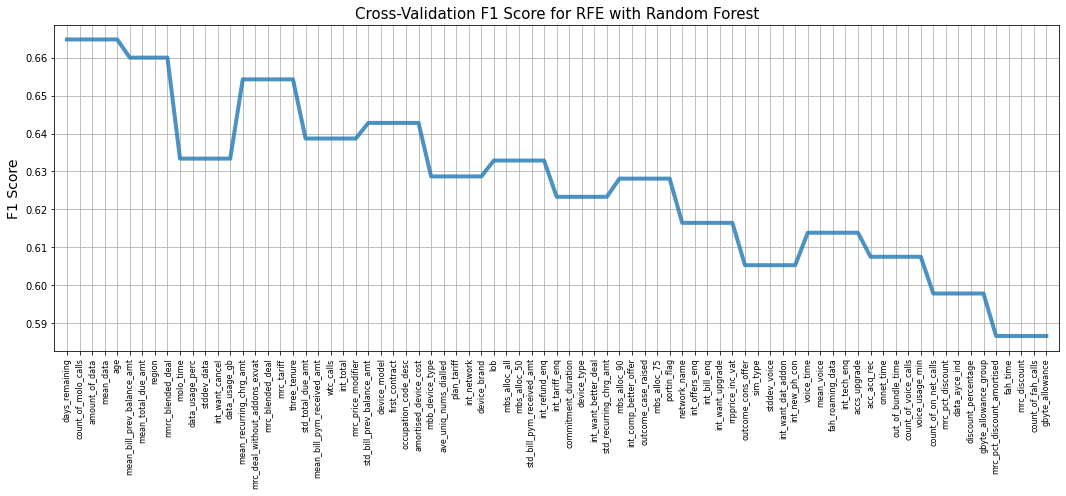

In [0]:
plt.figure(figsize=(18,6))

plt.plot(rfe_feature_ranking['f1'], linewidth=4, alpha=0.8)
plt.title('Cross-Validation F1 Score for RFE with Random Forest', fontsize=15)
plt.ylabel('F1 Score', fontsize=14)
plt.xlim([-1, len(rfe_feature_ranking)])
plt.xticks(rfe_feature_ranking.index, rfe_feature_ranking['feature'], rotation=90, fontsize=8)
plt.grid()

In [0]:
def get_performance_plots(feature_performance_rfe, feature_performance_vif, rfe_feature_ranking):

    """
    Plotting the performance of the best-models with the features selected with recursive feature elimination (RFE) and variance inflation factor (VIF)

    Parameters:
    - feature_performance_rfe (DataFrame): model performance with respect to number of top features (RFE)
    - feature_performance_vif (DataFrame): model performance with respect to number of top features (VIF)
    - rfe_feature_ranking (DataFrame): feature ranking

    Returns:
    
    """
    # Plotting the performance results for RFE vs. VIF - with VIF results obtained from another notebook and read in here
    plt.figure(figsize=(14,4))

    plt.subplot(1, 2, 1)
    plt.plot(feature_performance_rfe['f1 (test)'], linewidth=3.5, alpha=0.75)
    plt.plot(feature_performance_rfe['acc (test)'], linewidth=3.5, alpha=0.75)
    plt.title('Model Performance on Test Set (RFE)', fontsize=14)
    plt.xticks(feature_performance_rfe.index, feature_performance_rfe['feature_rank'].apply(lambda x : rfe_feature_ranking.loc[rfe_feature_ranking['rank'] <= x].shape[0]))
    plt.xlabel('Number of Top Features', fontsize=13)
    plt.ylabel('Score', fontsize=14)
    plt.legend(['F1 Score', 'Accuracy'], ncol=2)
    plt.xlim([-0.5, len(feature_performance_rfe)-0.5])
    plt.ylim([0.25, 0.92])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(feature_performance_vif['f1 (test)'], linewidth=3.5, alpha=0.75)
    plt.plot(feature_performance_vif['acc (test)'], linewidth=3.5, alpha=0.75)
    plt.title('Model Performance on Test Set (VIF)', fontsize=14)
    plt.xticks(feature_performance_vif.index, len(rfe_feature_ranking) - feature_performance_vif['no_eliminated_feature'])
    plt.xlabel('Number of Top Features', fontsize=13)
    plt.legend(['F1 Score', 'Accuracy'], ncol=2)
    plt.xlim([-0.5, len(feature_performance_vif)-0.5])
    plt.ylim([0.25, 0.92])
    plt.grid()

    plt.tight_layout()

In [0]:
def get_cross_validation(X_train_red, X_test_red, y_train, y_test):
    
    """
    Hyper-parameter optimization with grid search & cross-validation for the estimator of random forest

    Parameters:
    - X_train_red (DataFrame): train feature set with selected top features
    - X_test_red (DataFrame): test feature set with selected top features
    - y_train (Series): train response set
    - y_test (Series): test response set

    Returns:
    - best_params (dict): best parameter values for the model
    - best_score (float): best in-sample score
    - acc (float): accuracy on test set with the best parameter values
    - f1 (float): f1 score on test set with the best parameter values
    
    """

    # Hyper-parameter optimization with grid search and cross-validation
    param_grid = {'n_estimators' : [50, 100, 150, 250],
                 'max_depth' : [3, 5, None],
                 'min_samples_split' : [2, 5, 10],
                 'max_features' : ['sqrt', 'log2', None]}

    model = RandomForestClassifier()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
    clf = GridSearchCV(model, param_grid, n_jobs=5, cv=cv, scoring='f1', refit=True)
    clf.fit(X_train_red, y_train)
    
    best_params = clf.best_params_
    best_score = clf.best_score_

    prediction = clf.predict(X_test_red)
    acc, f1 = accuracy_score(y_test, prediction), f1_score(y_test, prediction)

    return best_params, best_score, acc, f1

In [0]:
# Best-model performance on the test set with an incremental sub-set of top features..

feature_performance = pd.DataFrame(columns=['feature_rank', 'best_params', 'f1 (train)', 'acc (test)', 'f1 (test)'])

for rank in range(1, rfe_feature_ranking['rank'].max()+1):

    selected_features = rfe_feature_ranking.loc[rfe_feature_ranking['rank'] <= rank, 'feature'].values
    print('Rank: {}, Top {} Features'.format(rank, len(selected_features)))

    X_train_red = X_train[selected_features].copy()
    X_test_red = X_test[selected_features].copy()
    
    best_params, best_score, acc, f1 = get_cross_validation(X_train_red, X_test_red, y_train, y_test)
    feature_performance = pd.concat([feature_performance, pd.DataFrame([dict(zip(feature_performance.columns, 
                                        [rank, best_params, best_score, acc, f1]))])], axis=0, ignore_index=True)
    # feature_performance.to_csv('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/feature_performance_rfe_v0.csv')

Rank: 1, Top 5 Features
Rank: 2, Top 9 Features
Rank: 3, Top 14 Features
Rank: 4, Top 19 Features
Rank: 5, Top 24 Features
Rank: 6, Top 29 Features
Rank: 7, Top 34 Features
Rank: 8, Top 39 Features
Rank: 9, Top 44 Features
Rank: 10, Top 49 Features
Rank: 11, Top 54 Features
Rank: 12, Top 59 Features
Rank: 13, Top 64 Features
Rank: 14, Top 69 Features
Rank: 15, Top 74 Features
Rank: 16, Top 79 Features


In [0]:
feature_performance_rfe = pd.read_csv('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/feature_performance_rfe.csv', index_col=0)
feature_performance_vif = pd.read_csv('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/feature_performance_vif.csv', index_col=0)
rfe_feature_ranking = pd.read_csv('/dbfs/dbfs/FileStore/shared_uploads/myucel@corpuk.net/cvm/rfe_feature_ranking.csv', index_col=0)

In [0]:
feature_performance_rfe.head()

,feature_rank,best_params,f1 (train),acc (test),f1 (test)
0,1,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.739679,0.897121,0.739821
1,2,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.743056,0.899031,0.746402
2,3,"{'max_depth': 5, 'max_features': None, 'min_sa...",0.743106,0.898349,0.745821
3,4,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.736868,0.890845,0.735799
4,5,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.738303,0.898485,0.745380


In [0]:
feature_performance_vif.tail()

,no_eliminated_feature,best_params,f1 (train),acc (test),f1 (test)
28,5,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.744902,0.899441,0.749234
29,4,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.744878,0.899441,0.749234
30,3,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.744907,0.899441,0.749234
31,2,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.744882,0.899441,0.749234
32,1,"{'max_depth': 3, 'max_features': None, 'min_sa...",0.744893,0.899441,0.749234


In [0]:
rfe_feature_ranking.head()

,feature,rank,f1
0,days_remaining,1,0.664791
1,count_of_molo_calls,1,0.664791
2,amount_of_data,1,0.664791
3,mean_data,1,0.664791
4,age,1,0.664791


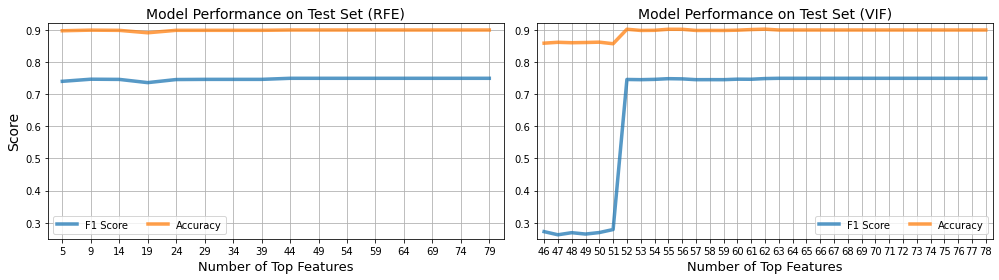

In [0]:
get_performance_plots(feature_performance_rfe, feature_performance_vif, rfe_feature_ranking)

In [0]:
feature_performance_rfe[['acc (test)', 'f1 (test)']].max()

Out[23]: acc (test)    0.899441
f1 (test)     0.749234
dtype: float64

In [0]:
feature_performance_vif[['acc (test)', 'f1 (test)']].max()

Out[24]: acc (test)    0.902033
f1 (test)     0.749234
dtype: float64